In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [38]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/aa_442300169800_engineered.csv')
# buat df baru hanya READ_DATE dan KWH_EXP saja
df = df[['READ_DATE', 'KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss']]
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres,Tavg,RH_avg,RR,ss
READ_DATE,,,,,,,,,,,
2019-02-26,5.370424,29.1,24.5,35.0,130.0,7.5,1009.4,28.6,79.0,0.0,10.9
2019-02-27,5.944421,28.5,24.5,34.0,126.0,7.3,1007.9,28.7,78.0,0.0,11.6
2019-02-28,5.425158,28.2,24.8,33.2,120.0,7.2,1008.2,28.0,83.0,0.0,11.6
2019-03-01,5.506770,28.3,24.8,32.8,81.0,7.1,1008.5,28.0,80.0,0.0,6.1
2019-03-02,5.817964,28.4,24.4,32.6,100.0,6.7,1008.5,27.8,82.0,0.0,8.9
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,8.532623,28.3,24.4,34.0,126.0,9.9,1009.9,28.7,73.0,0.0,10.4
2024-05-28,8.532623,28.2,24.1,33.9,125.0,8.0,1009.4,28.2,75.0,0.0,8.2
2024-05-29,8.337785,29.0,24.2,33.0,130.0,7.7,1009.1,29.0,77.0,0.0,10.7


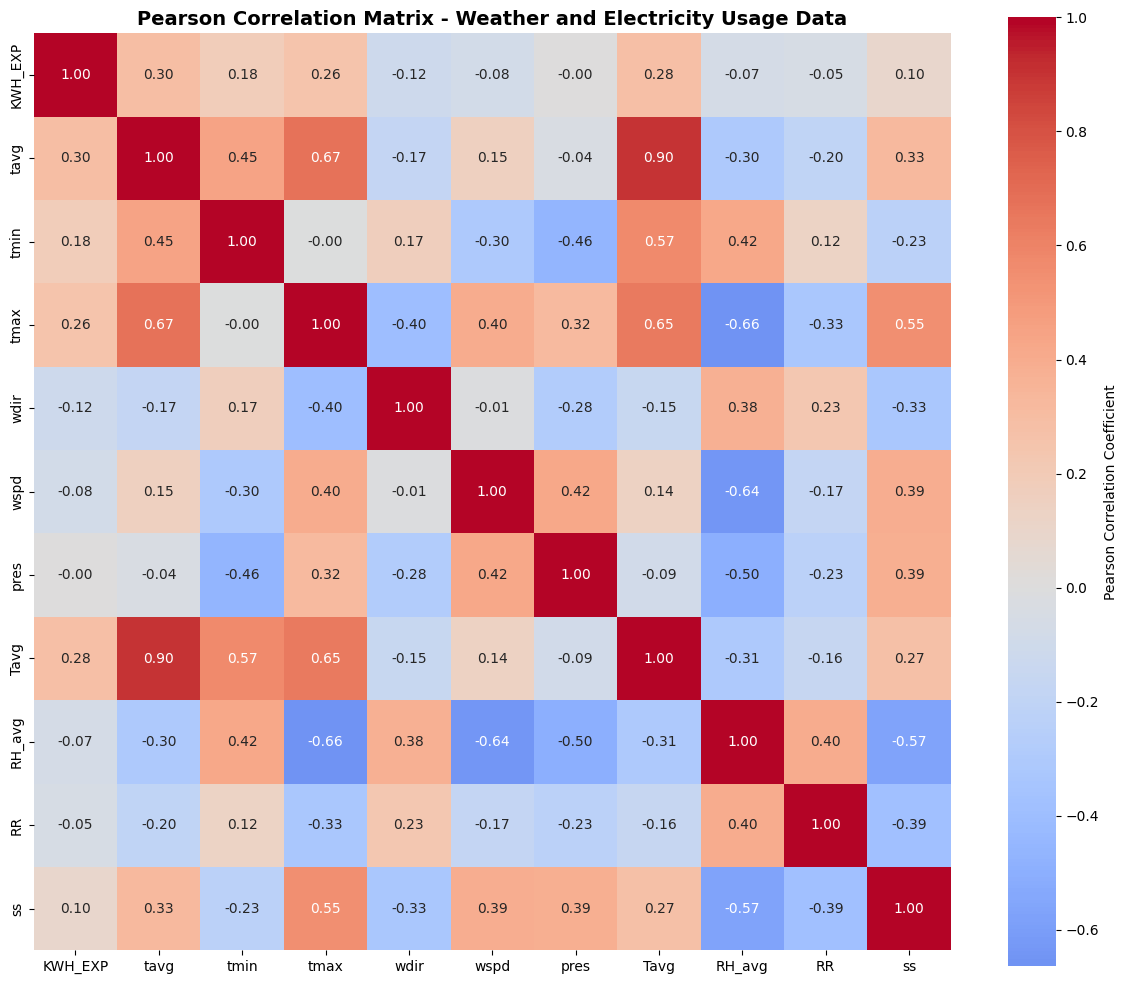

Correlation with KWH_EXP:
KWH_EXP    1.000000
tavg       0.295896
Tavg       0.281361
tmax       0.255822
tmin       0.183319
ss         0.096147
pres      -0.000414
RR        -0.051134
RH_avg    -0.069708
wspd      -0.079276
wdir      -0.116868
Name: KWH_EXP, dtype: float64


In [39]:
correlation_matrix = df.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,  # Tampilkan nilai korelasi
            cmap='coolwarm',  # Color map
            center=0,  # Pusat skala warna di 0
            square=True,  # Bentuk kotak
            fmt='.2f',  # Format angka 2 desimal
            cbar_kws={'label': 'Pearson Correlation Coefficient'})

plt.title('Pearson Correlation Matrix - Weather and Electricity Usage Data',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation with KWH_EXP:")
print(correlation_matrix['KWH_EXP'].sort_values(ascending=False))

In [40]:
df = df[['KWH_EXP', 'tmax', 'tmin', 'pres', 'tavg', 'ss']]
df

,KWH_EXP,tmax,tmin,pres,tavg,ss
READ_DATE,,,,,,
2019-02-26,5.370424,35.0,24.5,1009.4,29.1,10.9
2019-02-27,5.944421,34.0,24.5,1007.9,28.5,11.6
2019-02-28,5.425158,33.2,24.8,1008.2,28.2,11.6
2019-03-01,5.506770,32.8,24.8,1008.5,28.3,6.1
2019-03-02,5.817964,32.6,24.4,1008.5,28.4,8.9
...,...,...,...,...,...,...
2024-05-27,8.532623,34.0,24.4,1009.9,28.3,10.4
2024-05-28,8.532623,33.9,24.1,1009.4,28.2,8.2
2024-05-29,8.337785,33.0,24.2,1009.1,29.0,10.7


In [41]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE KWH_EXP	tavg	tmin	tmax	wdir	wspd	pres	Tavg	RH_avg	RR	ss
019-01-01	1.704497	25.7	24.8	30.2	44.0	6.4	1008.9	25.7	96.0	12.9	7.5
2019-01-02	1.804380	26.0	24.1	29.2	21.0	5.4	1009.2	25.9	90.0	42.7	6.7
2019-01-03	1.606232	24.6	24.0	27.3	340.0	4.1	1010.3	24.9	94.0	0.5	0.1
2019-01-04	1.220510	26.2	23.0	29.8	340.0	6.9	1011.4	25.8	88.0	34.6	0.1
2019-01-05	0.980424	26.9	23.6	30.2	284.0	6.3	1011.7	26.7	88.0	2.1	3.2
"""


train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [42]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_MA']])
# test_scaled_features = feature_scaler.transform(test)
# test_scaled_target = target_scaler.transform(test[['KWH_EXP_MA']])

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP']])


In [43]:
train_scaled_features

array([[ 0.23245265,  1.19831544,  0.7822    ,  0.08336328,  1.48845838,
         0.98488034],
       [ 0.40709426,  0.6056538 ,  0.7822    , -0.83072681,  0.91602662,
         1.22889535],
       [ 0.2491057 ,  0.13152448,  1.01487276, -0.6479088 ,  0.62981074,
         1.22889535],
       ...,
       [-1.09727749, -1.64646044,  0.54952724, -0.40415144, -1.564511  ,
        -0.06089831],
       [-0.97493805, -3.3651792 ,  0.39441207, -0.22133342, -1.564511  ,
        -2.11759631],
       [-1.04252062, -0.87600031,  1.01487276, -0.58696946, -0.22883689,
        -2.81478207]])

In [44]:
# # Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]

In [45]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)



Training model with selected features and timesteps = 1
Epoch 19: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


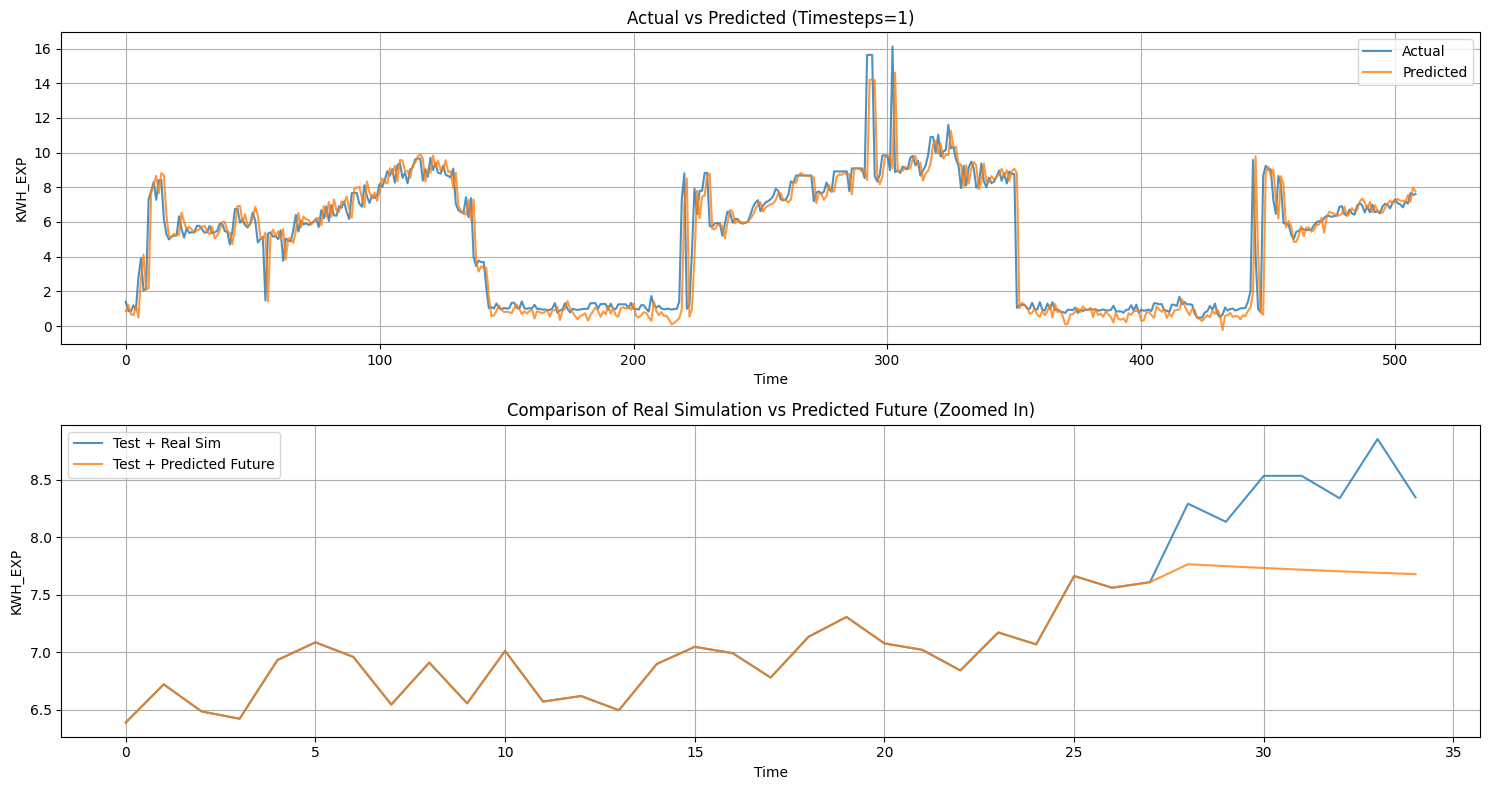


Metrics for timesteps=1:
MSE: 1.5161
R²: 0.8667
MAPE: 0.2230
MAE: 0.6229
Training time for timesteps = 1: 9.73 seconds

Training model with selected features and timesteps = 2
Epoch 17: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Results saved to bilstm_timestep_2_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


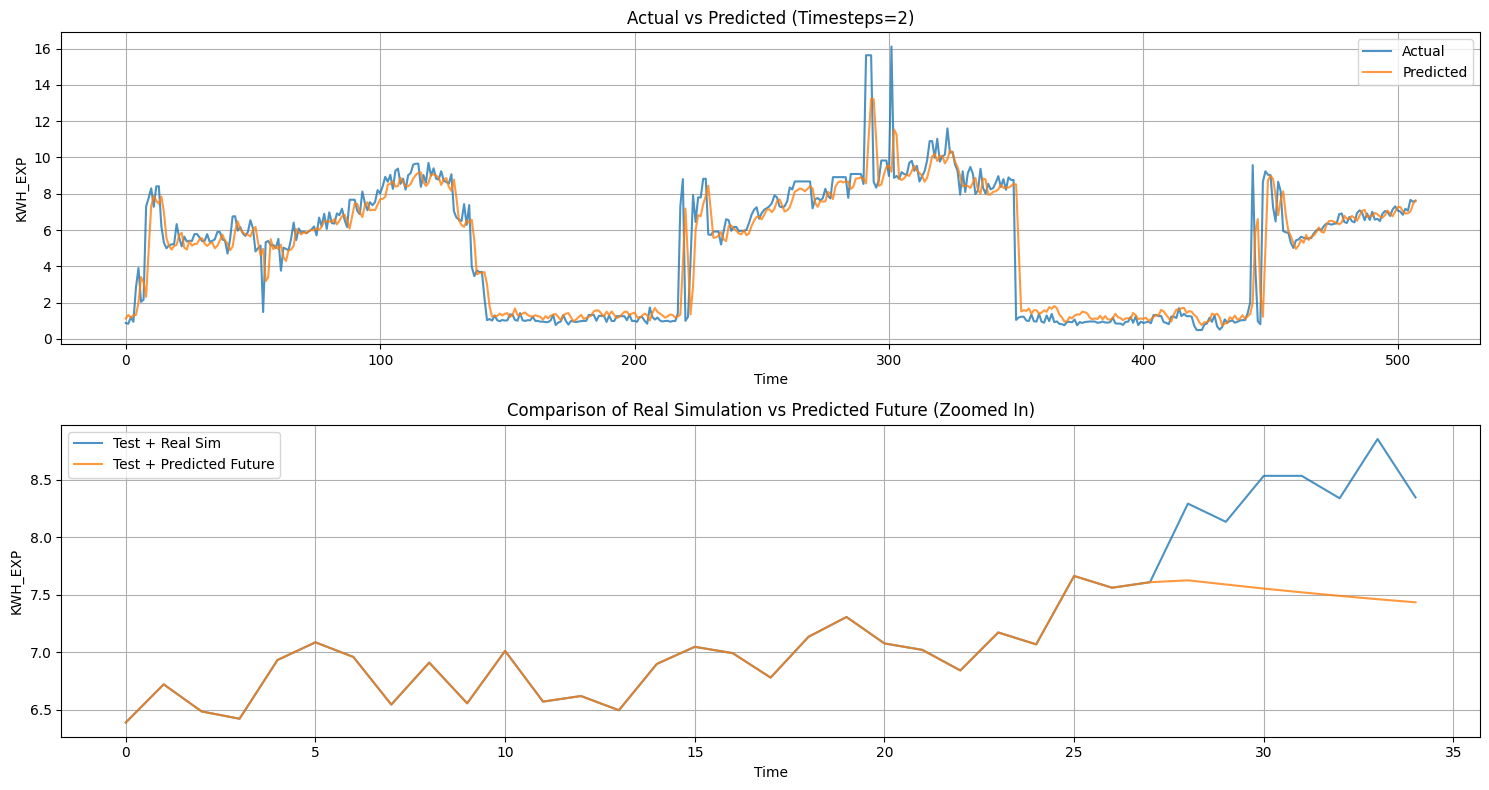


Metrics for timesteps=2:
MSE: 1.5094
R²: 0.8673
MAPE: 0.2329
MAE: 0.6363
Training time for timesteps = 2: 8.80 seconds

Training model with selected features and timesteps = 3
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


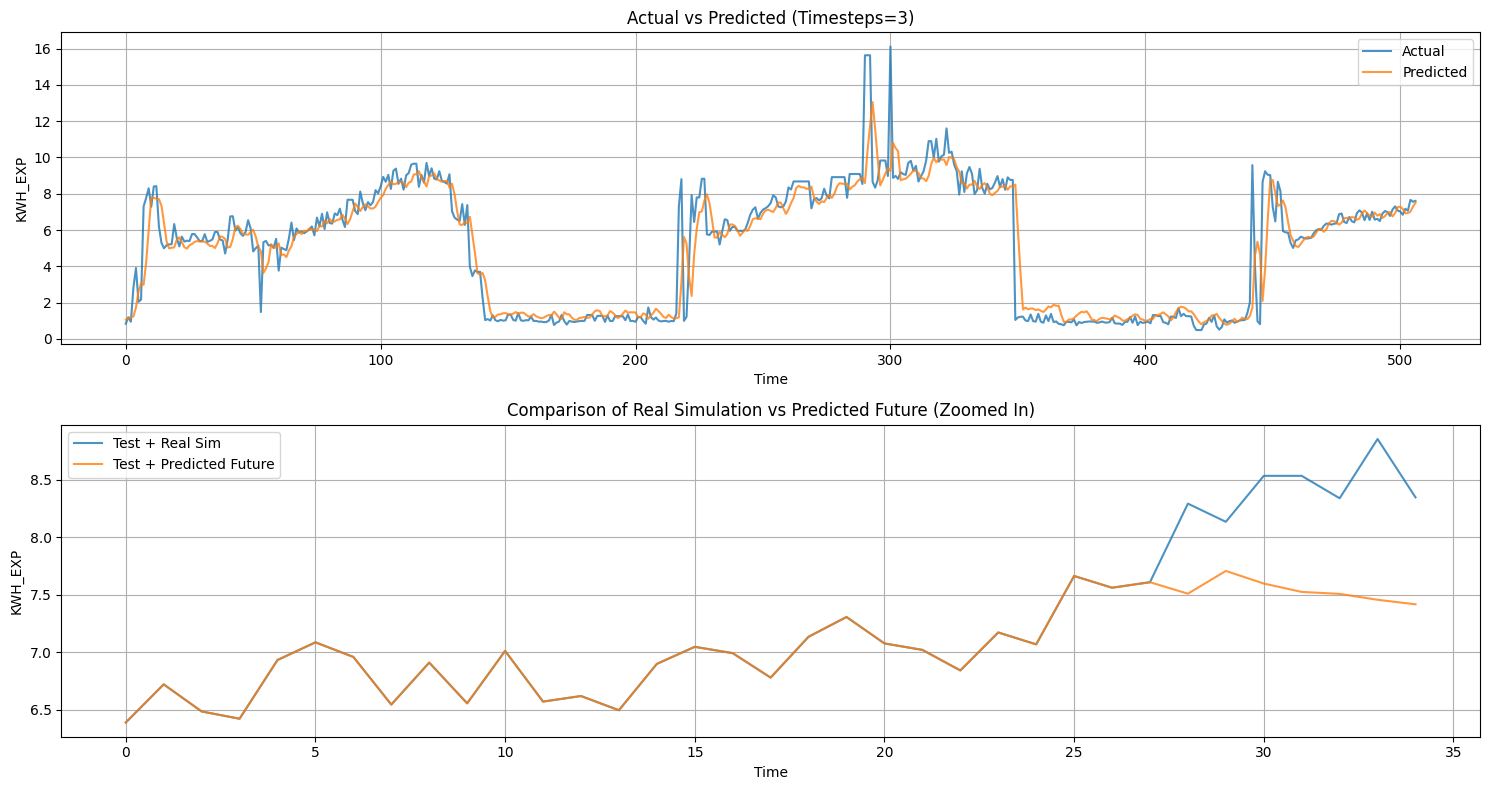


Metrics for timesteps=3:
MSE: 1.6127
R²: 0.8580
MAPE: 0.2455
MAE: 0.6748
Training time for timesteps = 3: 7.32 seconds

Training model with selected features and timesteps = 4
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Results saved to bilstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


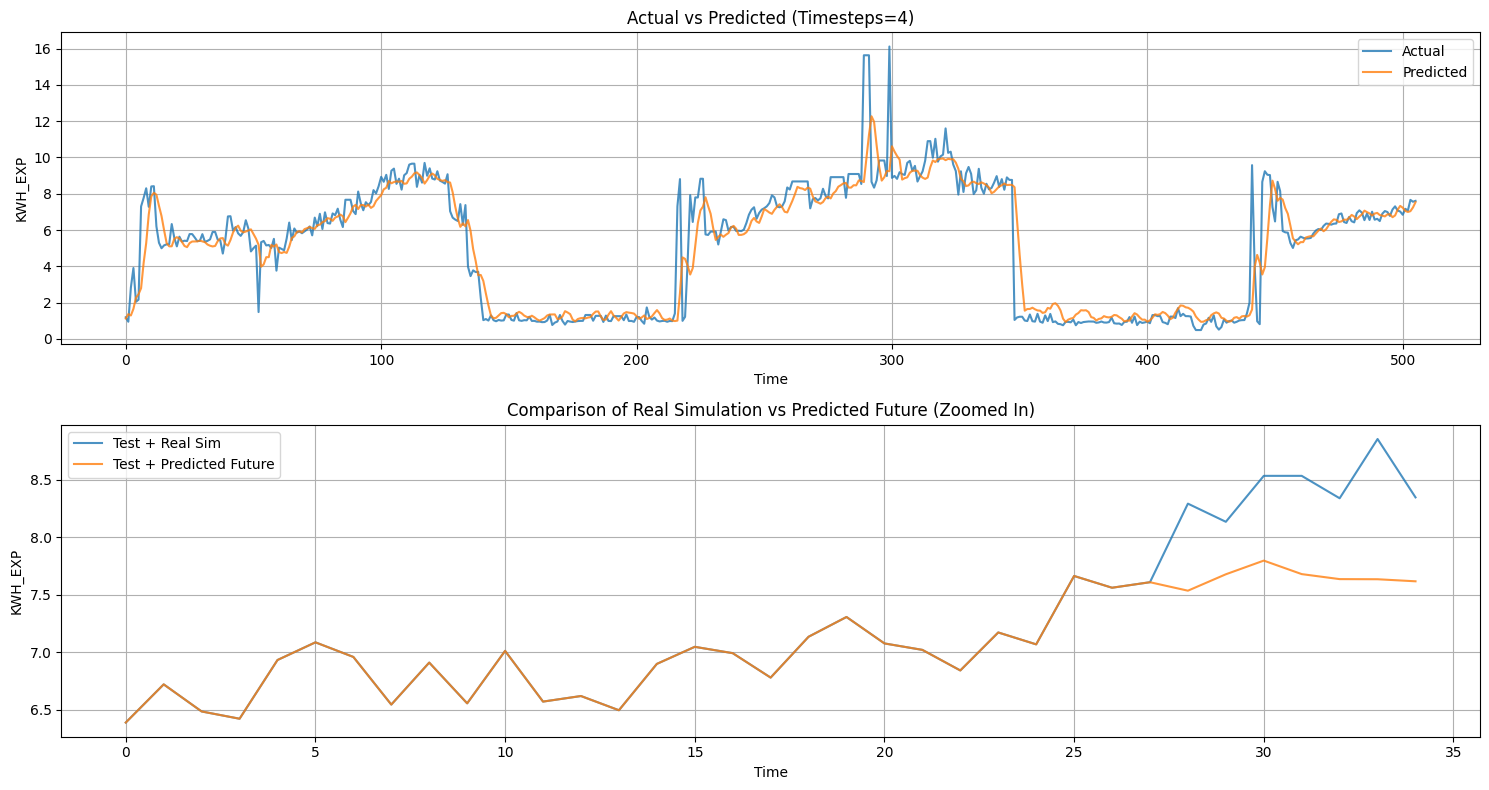


Metrics for timesteps=4:
MSE: 1.6157
R²: 0.8576
MAPE: 0.2477
MAE: 0.6827
Training time for timesteps = 4: 8.21 seconds

Training model with selected features and timesteps = 5
Epoch 11: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Results saved to bilstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


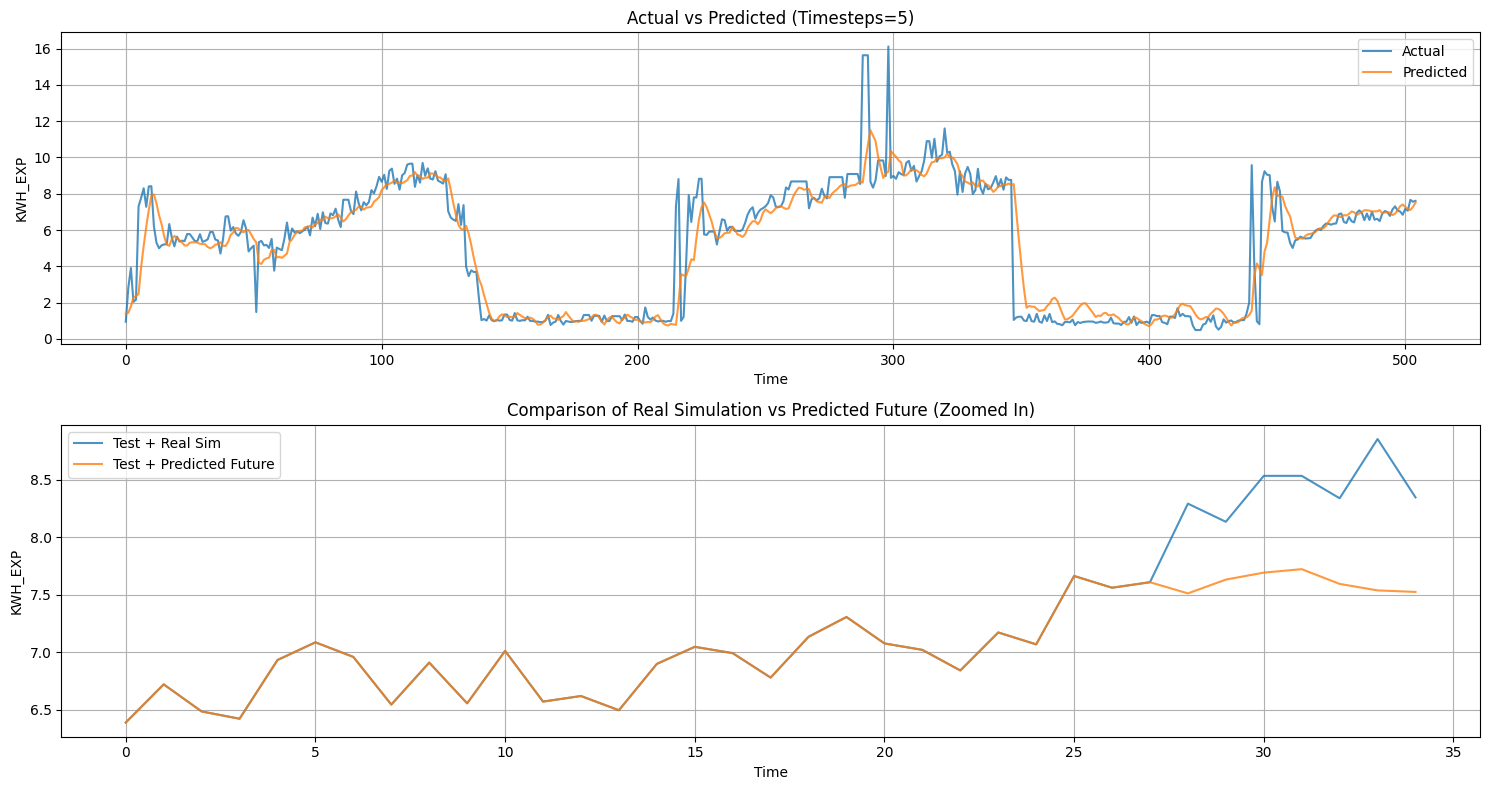


Metrics for timesteps=5:
MSE: 1.6905
R²: 0.8509
MAPE: 0.2626
MAE: 0.7132
Training time for timesteps = 5: 7.32 seconds

Training model with selected features and timesteps = 6
Epoch 16: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Results saved to bilstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


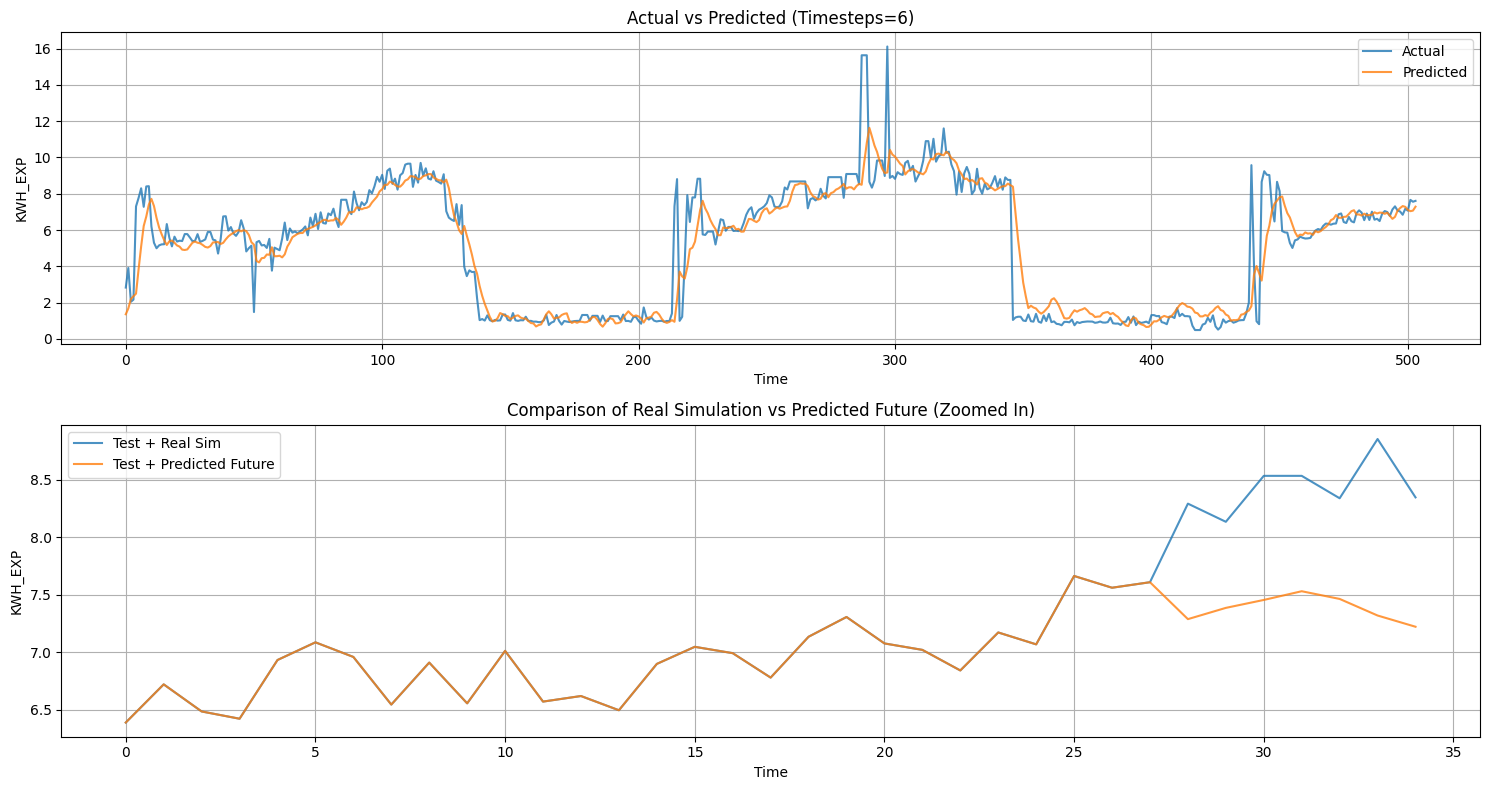


Metrics for timesteps=6:
MSE: 1.6776
R²: 0.8518
MAPE: 0.2698
MAE: 0.7165
Training time for timesteps = 6: 7.35 seconds

Training model with selected features and timesteps = 7
Epoch 10: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


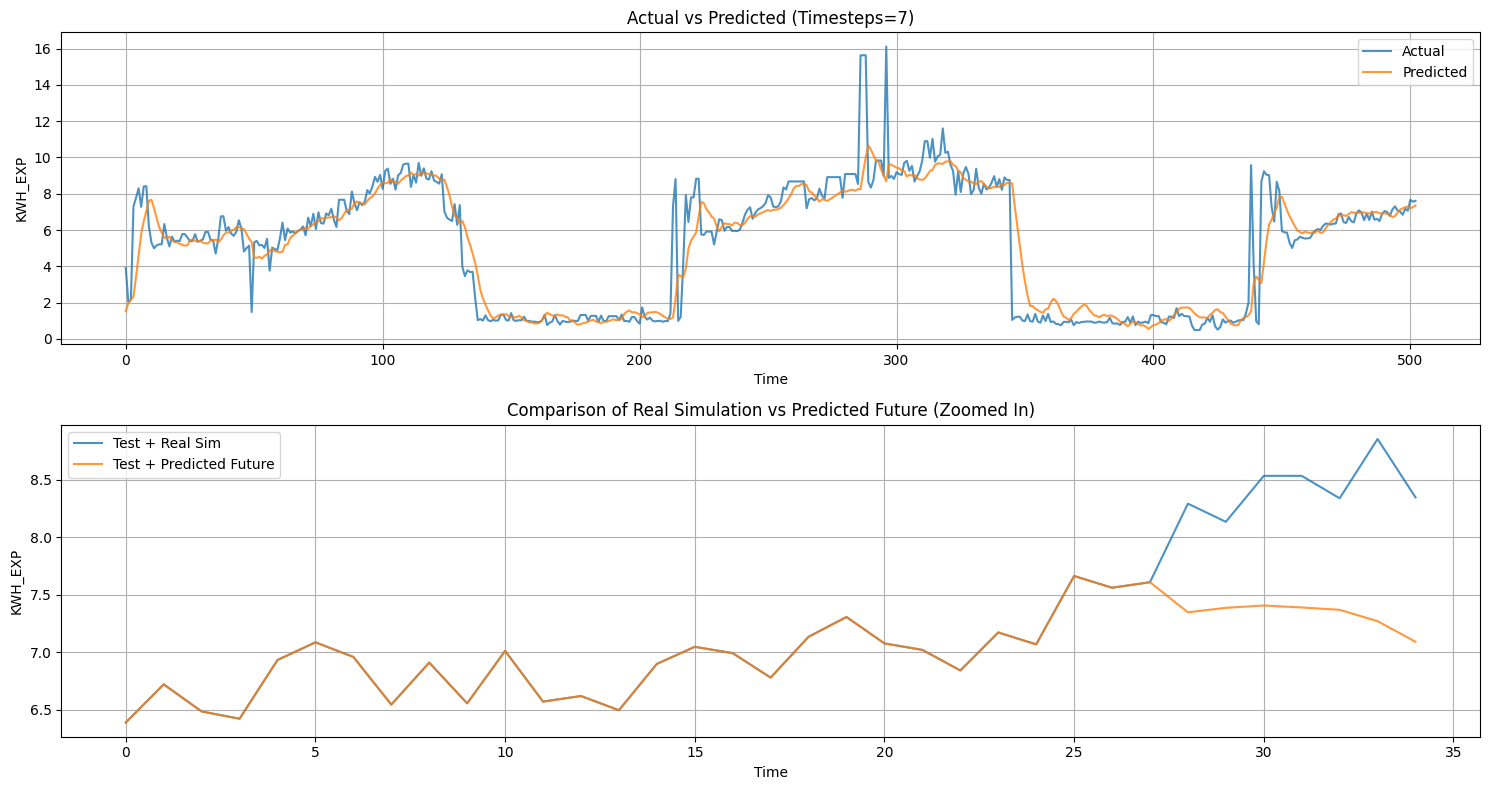


Metrics for timesteps=7:
MSE: 1.8330
R²: 0.8383
MAPE: 0.2802
MAE: 0.7410
Training time for timesteps = 7: 9.35 seconds
Total training execution time: 58.07 seconds


In [46]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:

    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [47]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [48]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 3, 4, 5, 6, 7]


Training model with selected features and timesteps = 1
Epoch 29: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


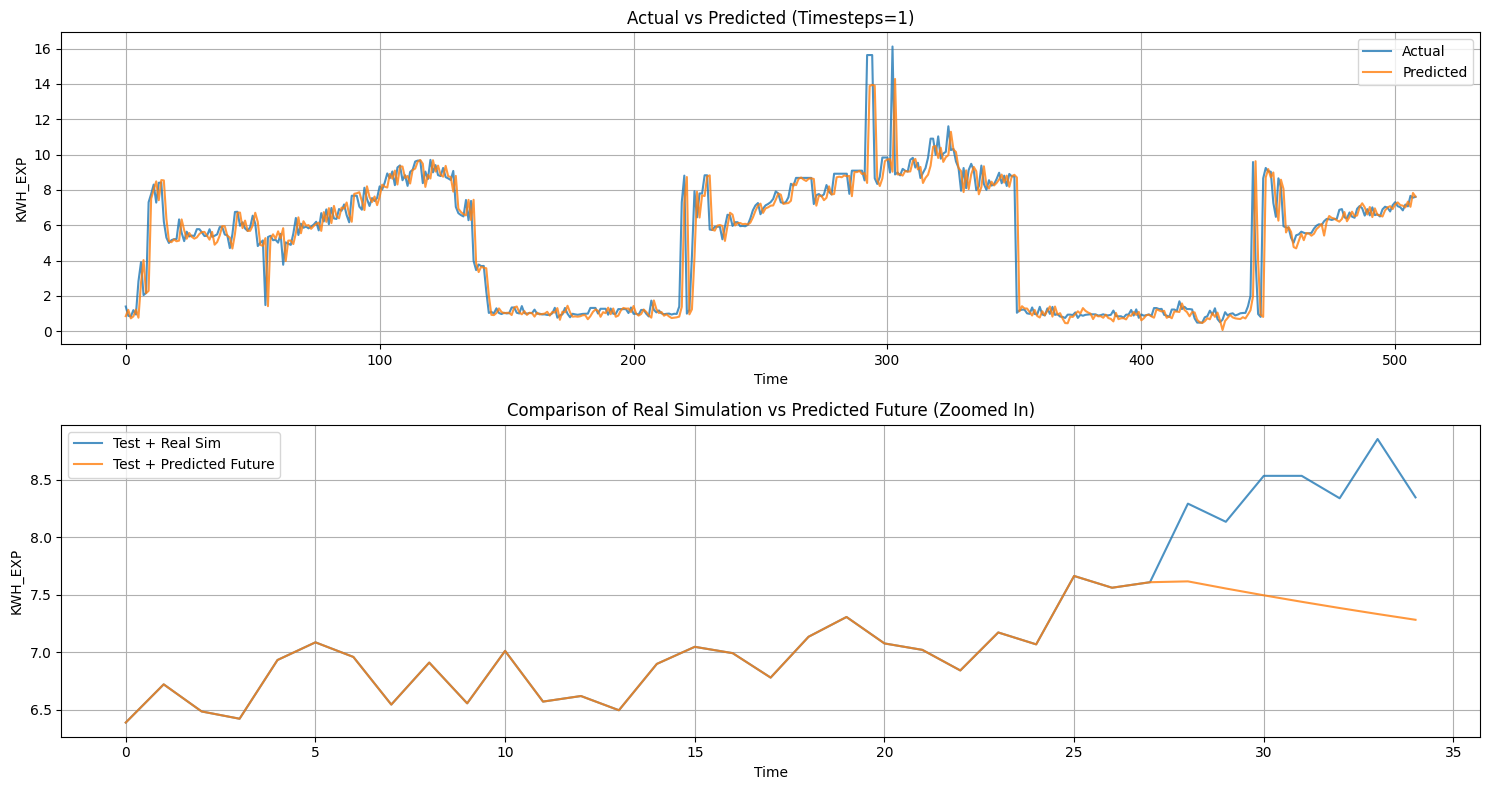


Metrics for timesteps=1:
MSE: 1.4271
R²: 0.8746
MAPE: 0.1771
MAE: 0.5618
Training time for timesteps = 1: 8.29 seconds

Training model with selected features and timesteps = 3
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


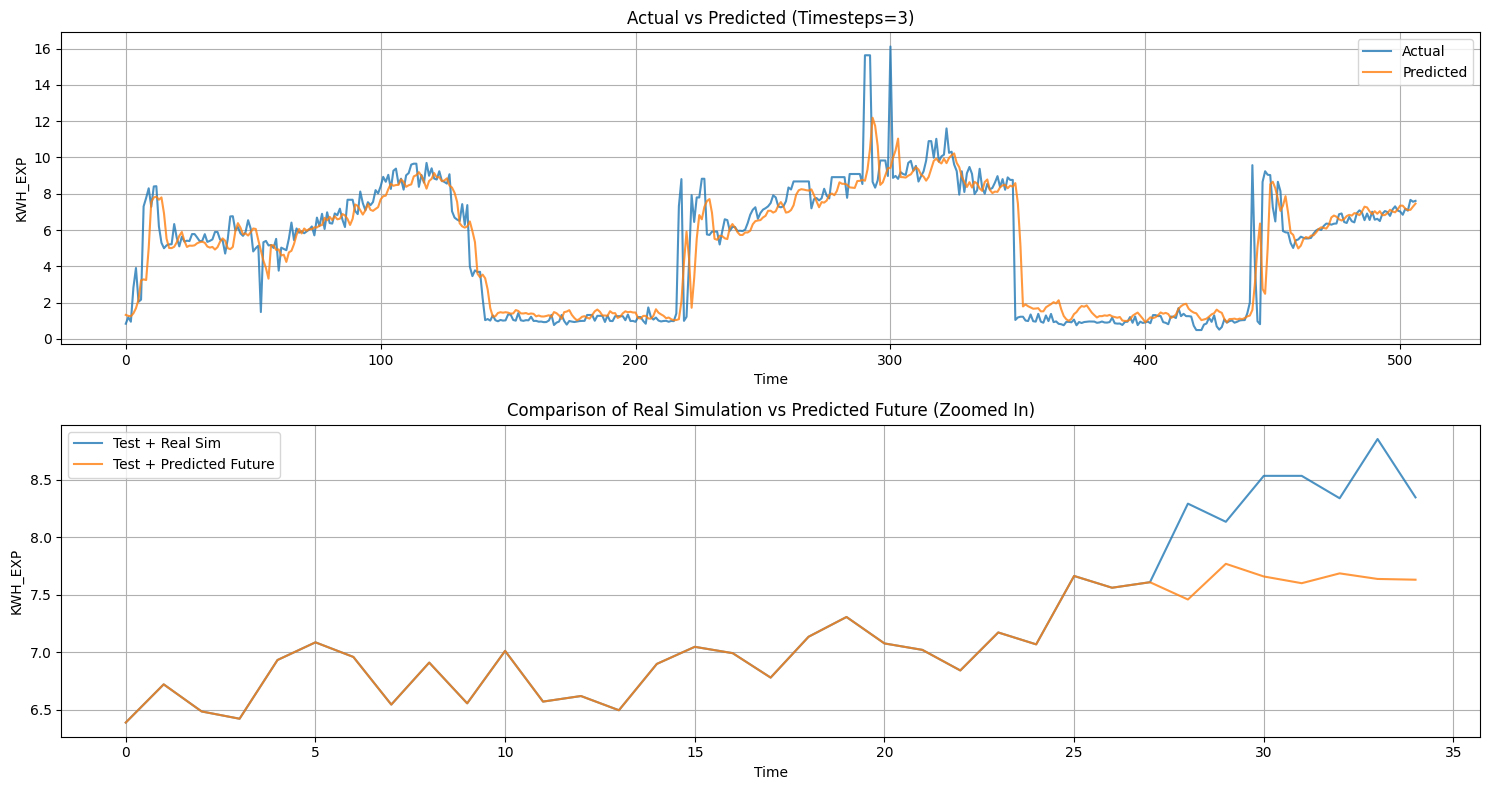


Metrics for timesteps=3:
MSE: 1.9103
R²: 0.8318
MAPE: 0.2845
MAE: 0.7510
Training time for timesteps = 3: 9.36 seconds

Training model with selected features and timesteps = 3
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


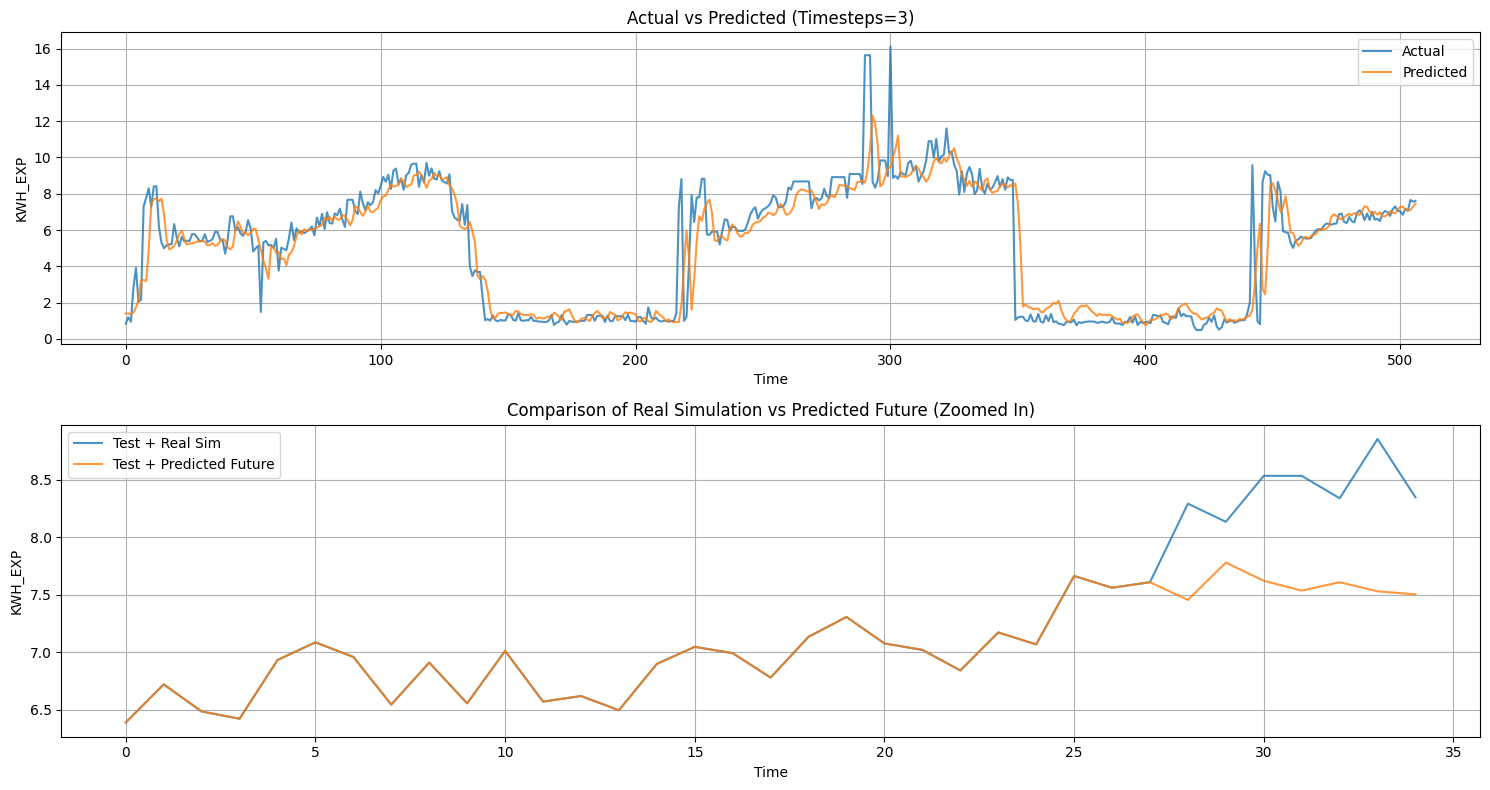


Metrics for timesteps=3:
MSE: 1.9426
R²: 0.8290
MAPE: 0.2800
MAE: 0.7572
Training time for timesteps = 3: 6.45 seconds

Training model with selected features and timesteps = 4
Epoch 15: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


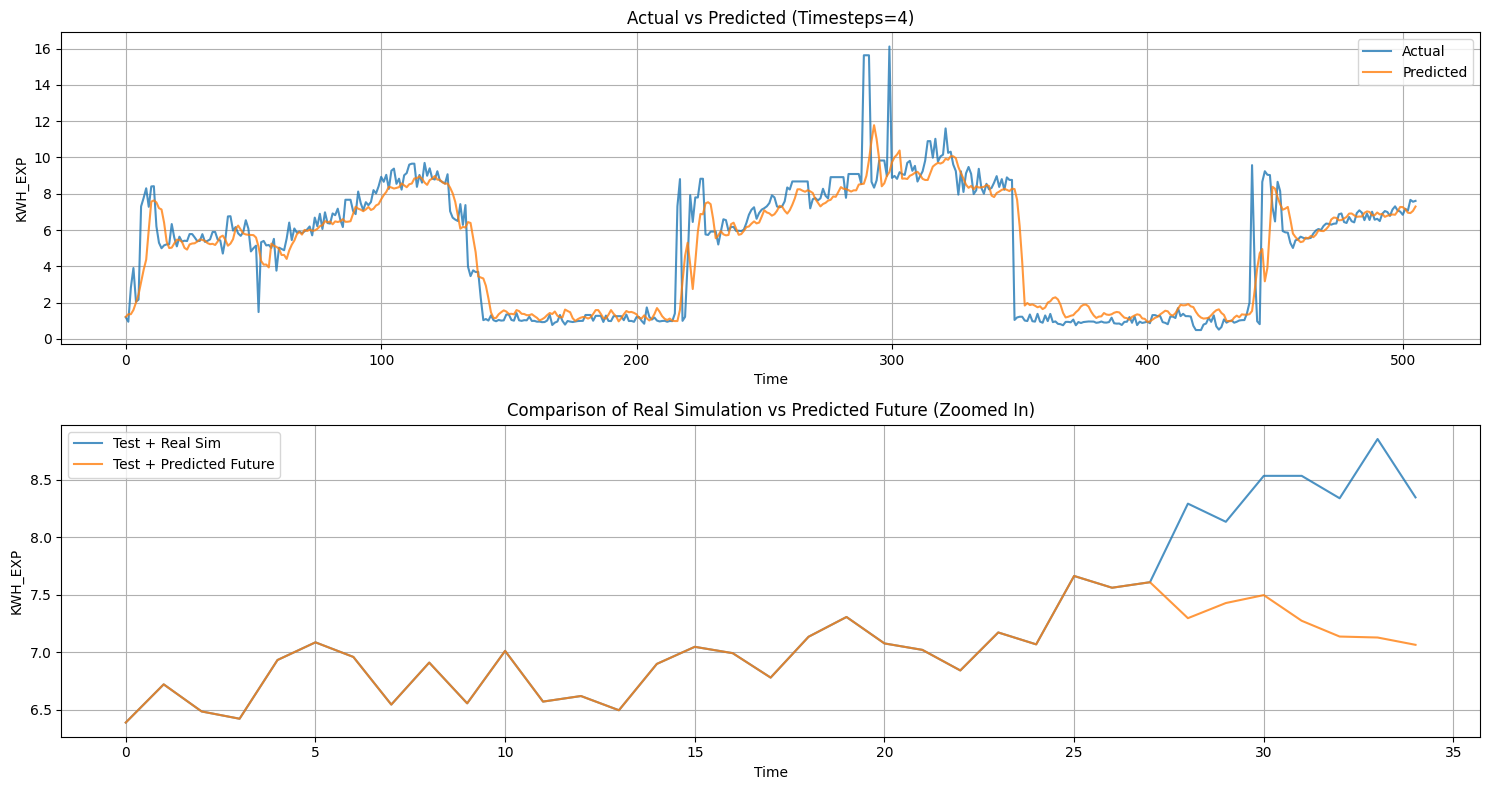


Metrics for timesteps=4:
MSE: 1.8980
R²: 0.8327
MAPE: 0.2943
MAE: 0.7768
Training time for timesteps = 4: 5.10 seconds

Training model with selected features and timesteps = 5
Epoch 15: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


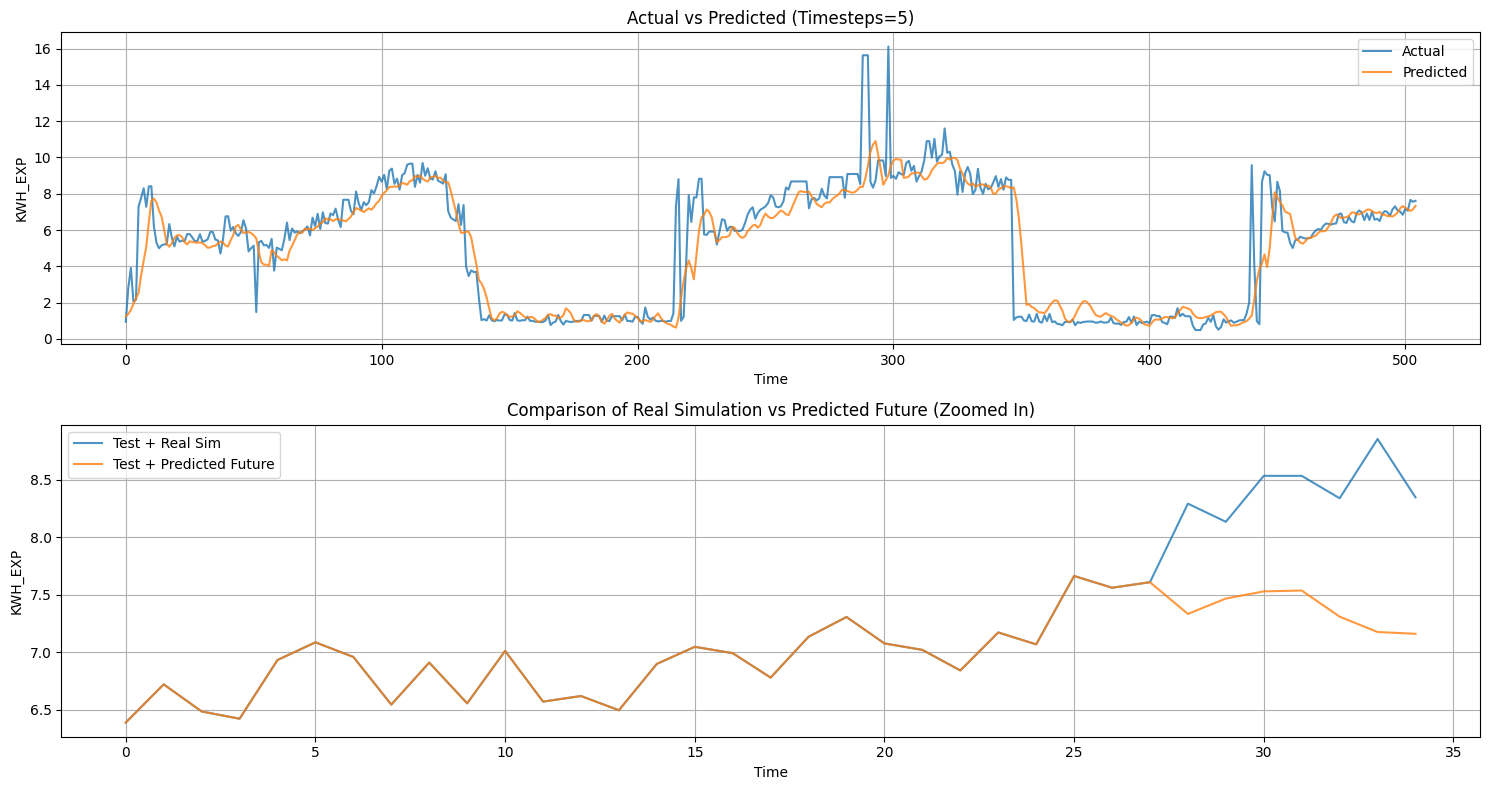


Metrics for timesteps=5:
MSE: 1.9841
R²: 0.8250
MAPE: 0.2740
MAE: 0.7881
Training time for timesteps = 5: 4.99 seconds

Training model with selected features and timesteps = 6
Epoch 13: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


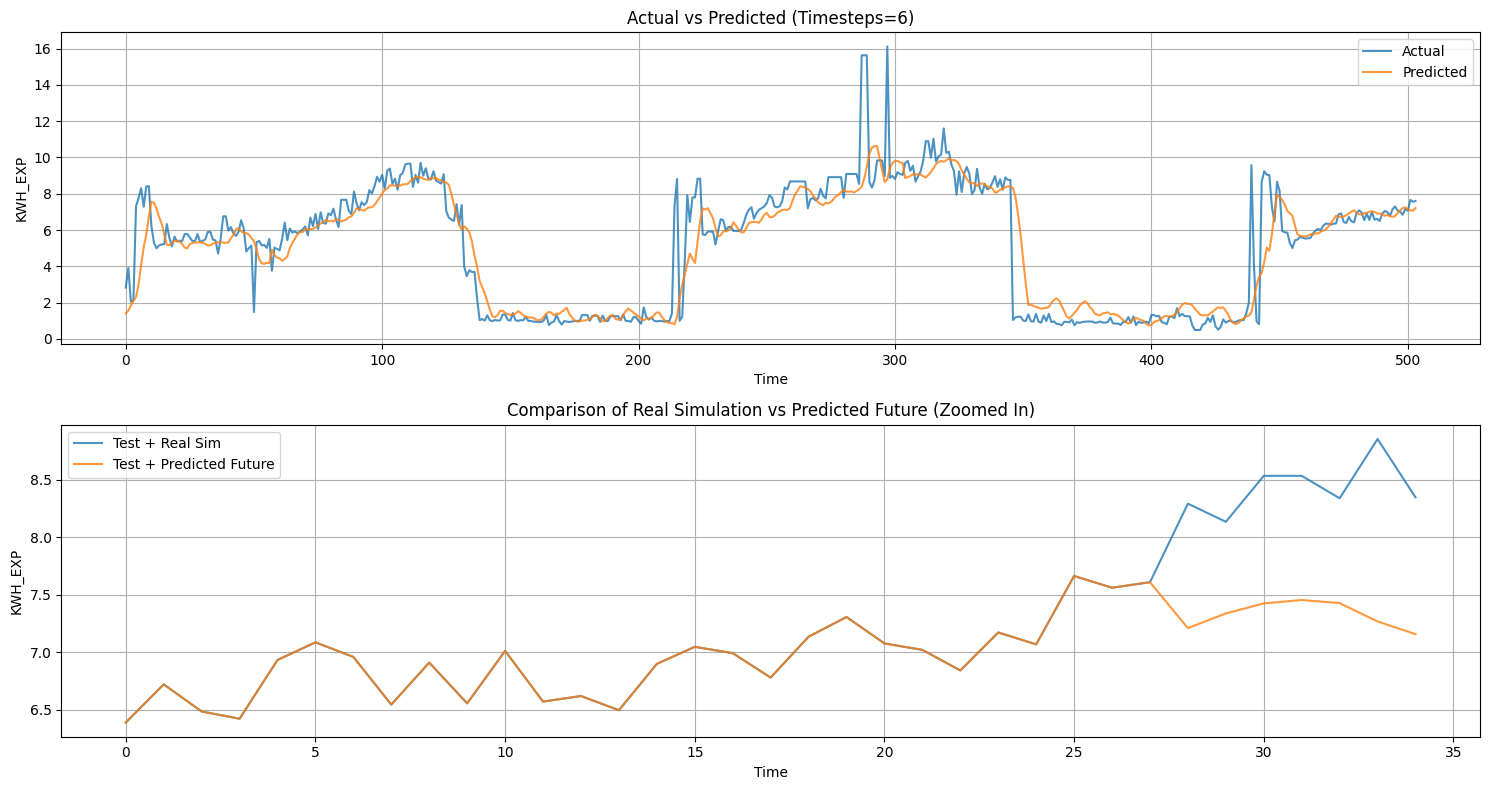


Metrics for timesteps=6:
MSE: 2.0639
R²: 0.8177
MAPE: 0.3061
MAE: 0.8194
Training time for timesteps = 6: 5.90 seconds

Training model with selected features and timesteps = 7
Epoch 13: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


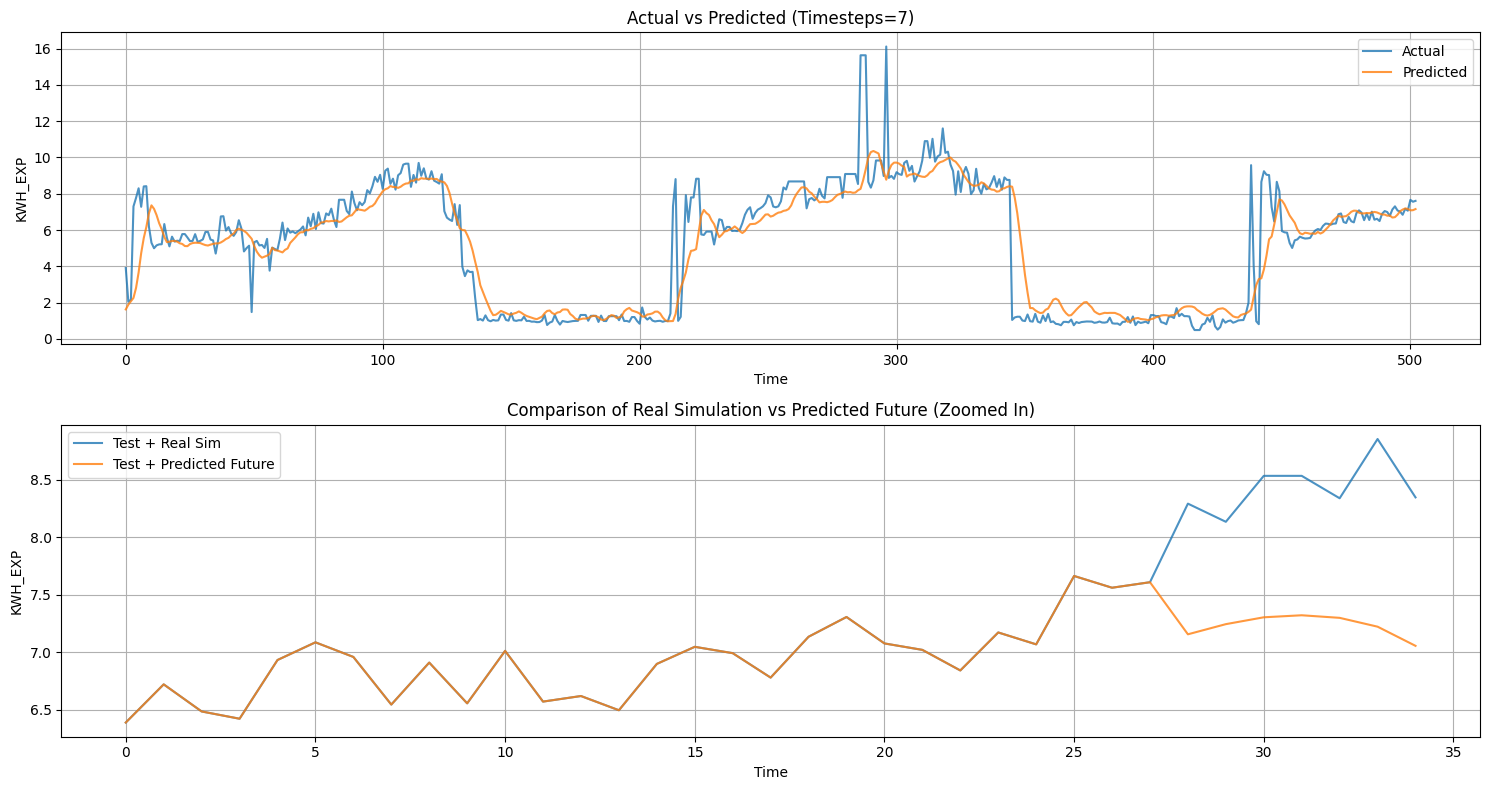


Metrics for timesteps=7:
MSE: 2.1115
R²: 0.8137
MAPE: 0.3188
MAE: 0.8286
Training time for timesteps = 7: 5.00 seconds
Total training execution time: 45.09 seconds


In [49]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")